In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

pd.options.display.max_columns = 50

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load datasets
train_df = pd.read_csv('train_df_cleaned.csv')
test_df = pd.read_csv('test_df_cleaned.csv')

# Preprocessing

## Outliers Detection

In [3]:
num_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']

# numerical features
print(num_features)

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [4]:
# select features we want to detect for outliers
selected_features = ['CreditScore', 'Age', 'Tenure', 'Balance','EstimatedSalary']

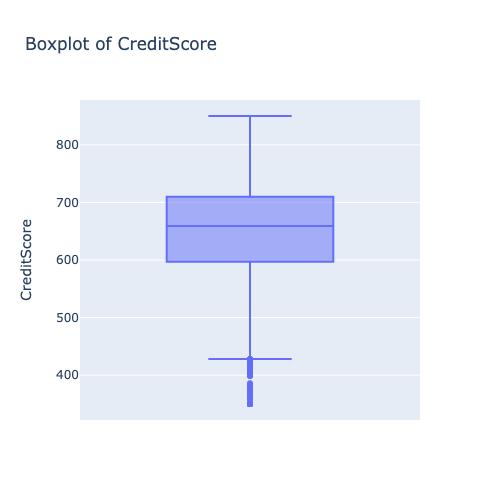

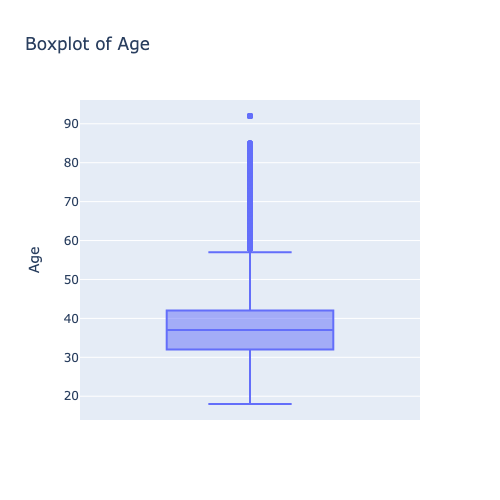

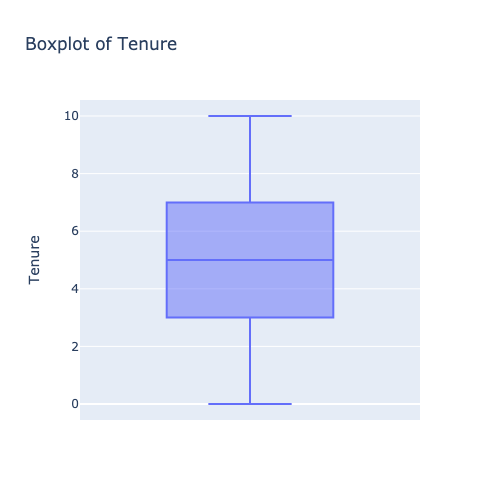

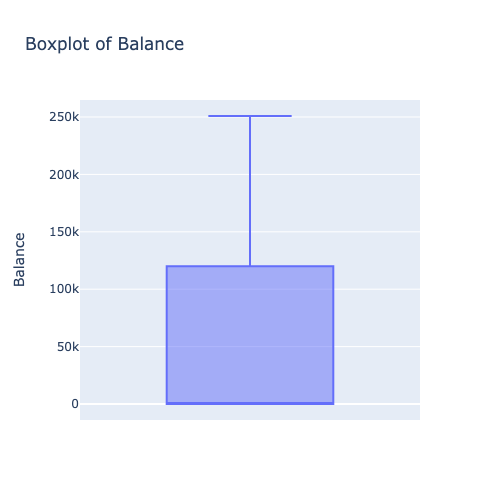

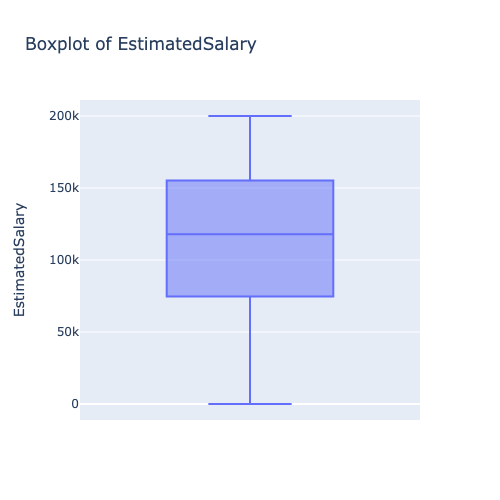

In [5]:
# create boxplots
for i in selected_features:
    fig = px.box(train_df,
                y=i,
                title=f'Boxplot of {i}')
    
    fig.update_layout(width=500,height=500)
        
    fig.show('png')

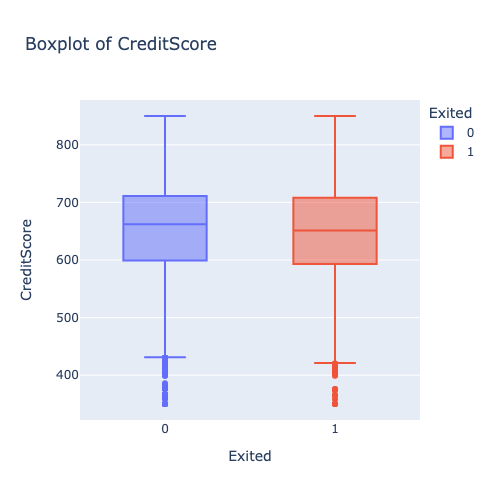

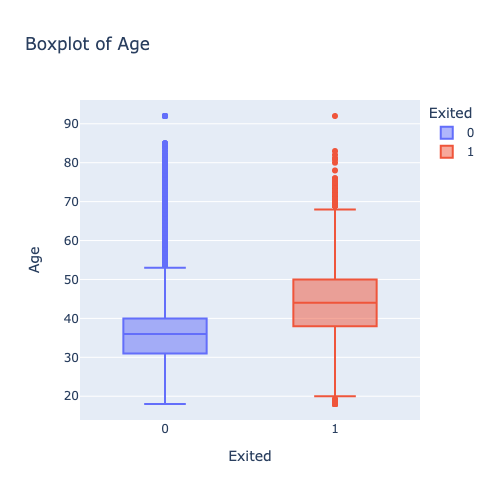

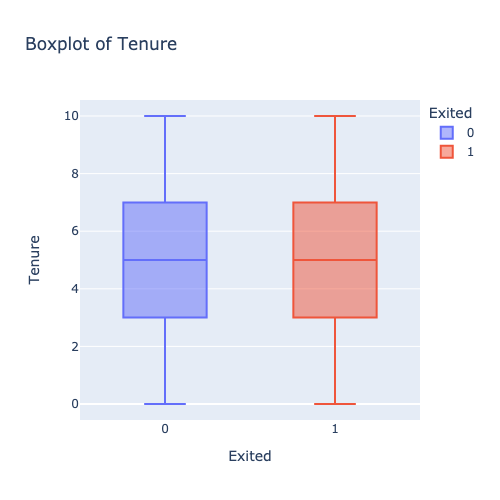

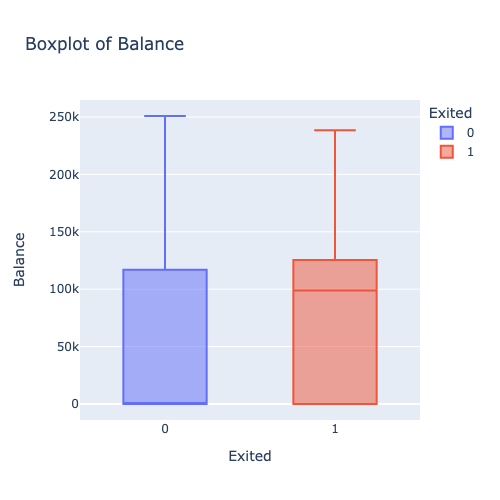

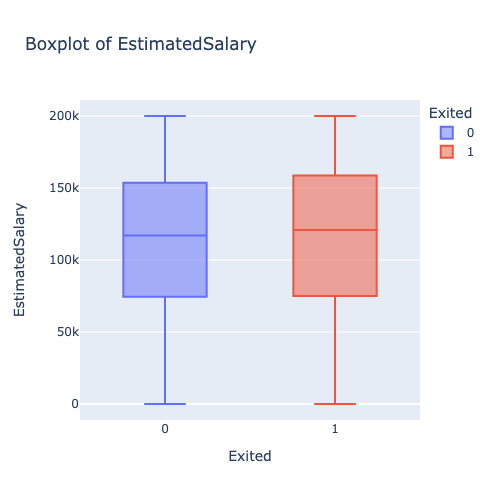

In [6]:
# create separate boxplots for churned and stayed users
for i in selected_features:
    fig = px.box(train_df,
                x='Exited',
                y=i,
                color='Exited',
                title=f'Boxplot of {i}')
    
    fig.update_layout(width=500,height=500)
        
    fig.show('png')

Let's look at some of the outliers from `Age` and `CreditScore` column, and see if they contain any predictive information.

In [7]:
# users older than 
age_outliers = train_df[train_df['Age']>=92]

age_outliers['Exited'].value_counts()

0    10
1     1
Name: Exited, dtype: int64

In [8]:
# users with low credit scores
credit_outliers = train_df[train_df['CreditScore']<=386]

# how many of these users churned
credit_outliers['Exited'].value_counts()

0    41
1    12
Name: Exited, dtype: int64

These outliers have some degree of predictive power and they are not rare and erroneous data, we will not drop them for now.

## Vectorizing Surname

Like we saw early, there are multiple names under the same account, same geographical region. The `Surname` column may also contain preditive information in terms of cultural, ethical, and geographical background. I will use TF-IDF for this step:
- Sometimes, the presence of shared surnames could identify family accounts, and patterns in churn could be related to household-level decisions rather than individual ones. 
- Uncommon or rare name sequences might be related to certain demographic groups that have different behaviors when it comes to bank churn.
- The vectorized name feature might be combined with other demographic or behavioral features to create a richer set of predictors that could improve the performance of churn prediction models.
-  If names can reflect cultural, ethnic, or regional backgrounds, and if such backgrounds are somehow correlated with churn rates, then TF-IDF might be able to capture these nuances by highlighting unique name segments. 

**Term Frequency (TF)**<br>
Term Frequency in the context of names would calculate how often parts of names (like n-grams, which could be sequences of characters) occur within each name. We are using character n-grams, this could highlight certain sequences of letters that are more common in names associated with churned customers.

**Inverse Document Frequency (IDF)**<br>
Inverse Document Frequency weighs these terms based on how common or rare they are across all names in the dataset. For example, if a certain sequence of letters is very common across many customers, it will be given a lower weight as it is not distinctive enough. On the other hand, rare sequences get a higher weight.


**Caveats and Consideration**<br>
TD-IDF on names would create a very sparse matrix with wmany dimensions, which could be very computationally expensive. Therefore I will use dimensionality reduction method TruncatedSVD (which is often used in text analysis where term-document matrix is sparse) to mitigate such issue.

In [9]:
# before fit the vectorization, I will need to determine how many n-grams I should be using to mitigate the issue of large dimensionality

# max number of words contained in a surname
max(train_df['Surname'].str.split().str.len())

3

In [10]:
# instantiate TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,3),
                       max_features=1000,
                       analyzer = 'word',
                       # this parameter applies sublinear scaling 1 + log(tf) instead of tf to diminish the influence of frequently occurring words
                       sublinear_tf=True)

# fit transform on data setse
tfidf_train = tfidf.fit_transform(train_df['Surname'])
tfidf_test = tfidf.transform(test_df['Surname'])

In [11]:
# dimensionality reduction
svd = TruncatedSVD(n_components=3)

# fit transform
svd_train = svd.fit_transform(tfidf_train)
svd_test = svd.transform(tfidf_test)

# convert to dataframe
svd_train_df = pd.DataFrame(svd_train)
svd_test_df = pd.DataFrame(svd_test)

In [12]:
# rename columns
columns = [('Surname_tfidf_' + str(x)) for x in svd_train_df.columns.to_list()]

svd_train_df.columns = columns
svd_test_df.columns = columns

In [13]:
# concatenate vectorizations to the original datasets
train_df = pd.concat([train_df,svd_train_df],axis=1)
test_df = pd.concat([test_df,svd_test_df],axis=1)

In [14]:
# drop Surname column
train_df = train_df.drop(columns='Surname')
test_df = test_df.drop(columns='Surname')

In [15]:
# check
train_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeBin,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,30-39,4.309290e-07,1.596258e-06,3.883117e-06
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,30-39,8.867709e-07,3.624331e-06,9.383997e-07
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,40-49,2.096810e-03,2.348042e-03,8.589801e-03
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,30-39,-3.480917e-03,-7.903973e-03,-2.737991e-02
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,30-39,1.881985e-08,7.103675e-07,4.292694e-06


In [16]:
test_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2
0,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75,0.000036,0.000058,0.000171
1,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27,0.000000,0.000000,0.000000
2,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09,0.000000,0.000000,0.000000
3,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57,-0.000007,-0.000016,-0.000036
4,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00,0.000000,0.000000,0.000000


## Feature Engineering

Feature engineering is a crucial step in enhancing machine learning models by creating new features from exisiting ones, which can help in capturing more complexity and potentially revealing more insights about the data. I will create some new features to feed to our models.

### Age Groups 

We already created the age bins for the train set in the previous steps, I will do the same for the test set.

In [17]:
# define bin edges
bins = [18,30,40,50,60,70,80,93]

# define group names
bin_names = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-93']

# divide the users into age brackets
test_df['AgeBin'] = pd.cut(test_df['Age'], bins=bins, labels=bin_names, right=False)

In [18]:
# check
test_df['AgeBin'].value_counts()

30-39    54035
40-49    29190
18-29    15611
50-59     7996
60-69     2577
70-79      532
80-93       46
Name: AgeBin, dtype: int64

### Salary Group

Similar to age groups, bin `EstimatedSalary` into differnet salary ranges taht might correlate with churn

In [19]:
# list of datasets 
dfs = [train_df, test_df]

# loop through the list
for df in dfs:
    
    df['SalaryGroup'] = pd.qcut(df['EstimatedSalary'], q=4, labels=['low','medium','high','very high'])

### Customer Value Index

In the context of banking, a "Customer Value Index" could be a composite metric designed to estimate the overall value of a customer to the bank. This metric often combines several indicators of a customer's behavior, profitability, and engagement to create a single score. Here, I will total up each banking components, multiply the weights which I am assigning to each of the component, divided by the user's tenure. 

In [20]:
# add customer value index for train, test set

# loop through the list
for df in dfs:
    
    df['CustomerValueIndex'] = round((df['Balance'] + (df['NumOfProducts']*1000) + (df['IsActiveMember']*500) + (df['HasCrCard']*500)) / (df['Tenure'] + 1), 2) #add 1 to prevent 0 in the denominator

In [21]:
train_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeBin,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,SalaryGroup,CustomerValueIndex
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,30-39,4.309290e-07,1.596258e-06,3.883117e-06,very high,625.00
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,30-39,8.867709e-07,3.624331e-06,9.383997e-07,low,1500.00
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,40-49,2.096810e-03,2.348042e-03,8.589801e-03,very high,227.27
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,30-39,-3.480917e-03,-7.903973e-03,-2.737991e-02,medium,50294.18
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,30-39,1.881985e-08,7.103675e-07,4.292694e-06,low,500.00


### Check Multicolliearity

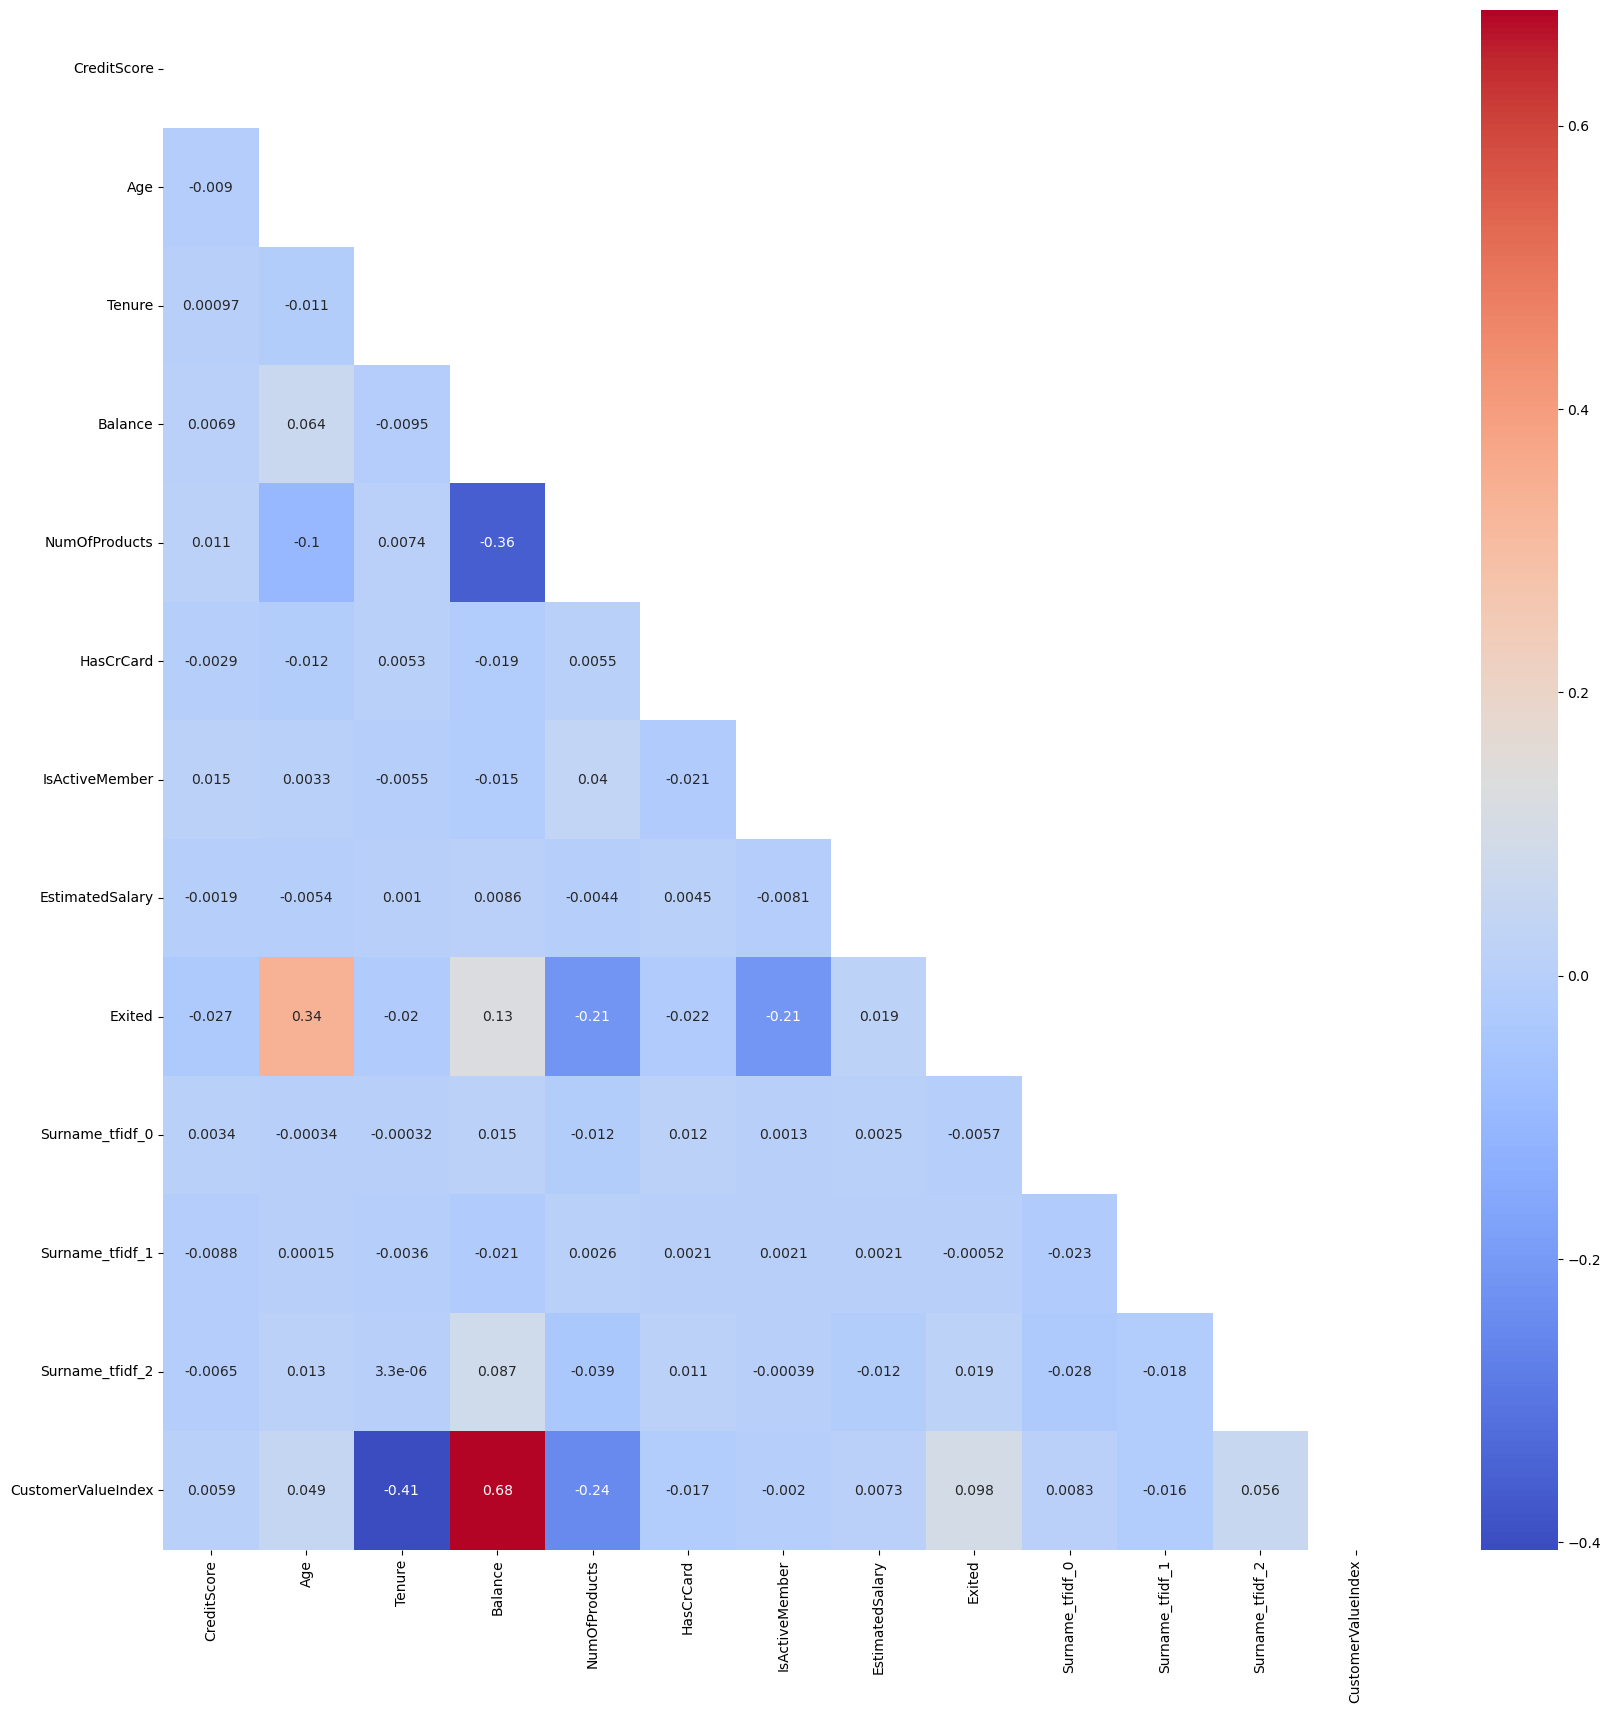

In [22]:
# define correlation matrix and mask
corr_matrix = train_df.corr()
mask = np.triu(np.ones_like(corr_matrix,dtype=bool))

plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix,
           mask=mask,
           annot=True,
           cmap='coolwarm')

plt.show()

`EstimatedSalary` has 0.71 correlation with `SalaryGroup_very_high` which is considered as multicollinearity, I will drop it.

In [23]:
# drop EstimatedSalary
train_df.drop(columns='EstimatedSalary',inplace=True)
test_df.drop(columns='EstimatedSalary',inplace=True)

## Transforming Numerical Features

In [24]:
# look at the distribution of continuous numerical features again
features = ['CreditScore', 'Age', 'Balance']

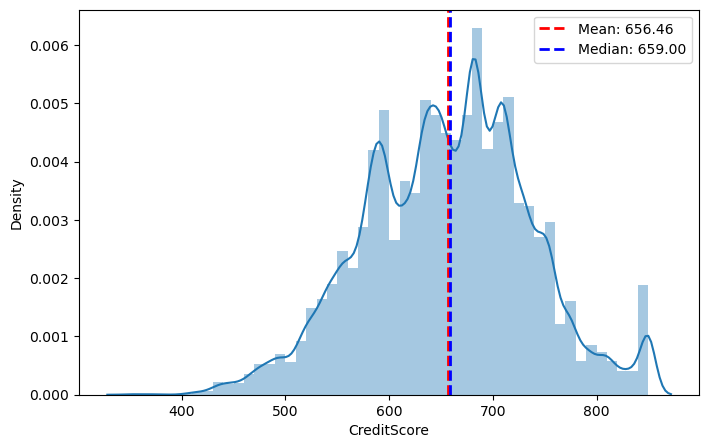

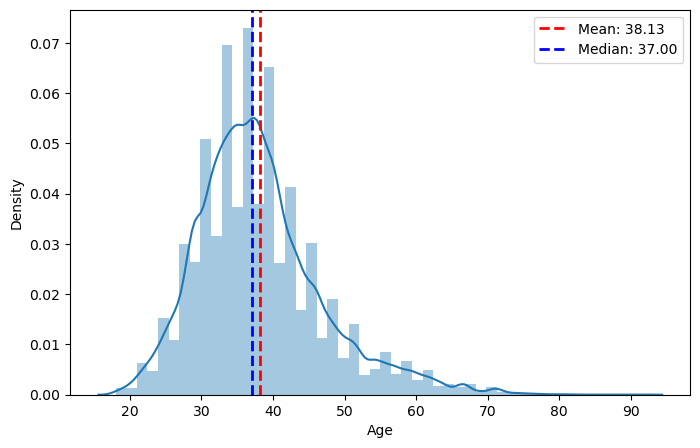

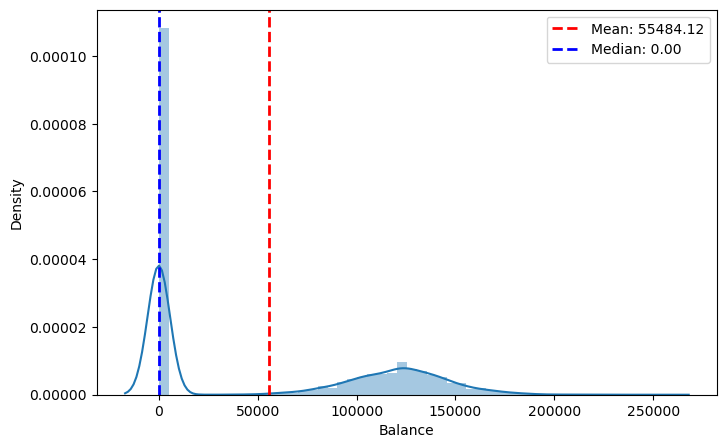

In [25]:
for col in features:
    
    mean = train_df[col].mean()
    median = train_df[col].median()
    
    plt.figure(figsize=(8,5))
    sns.distplot(train_df[col],
                kde=True)
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
    
    plt.legend()
    
plt.show()

The mean and median of the `CreidtScore` column are somewhat of the same value, `Age` is slightly right skewed. the majoriity of the data of `Balance` column are clustered at 0, makes the column heavily left skewed, Logrithm transformation should be a good technique here, but we need to add a small constant to the column before we apply this technique as the logarithm of zero and negative numbers is undefined.

In [26]:
train_df['Balance'] = train_df['Balance']+1.0

In [27]:
train_df['Balance'] = np.log(train_df['Balance'])

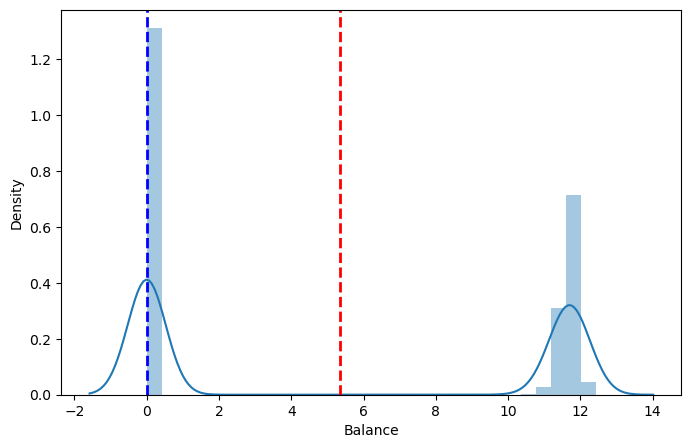

In [28]:
mean = train_df['Balance'].mean()
median = train_df['Balance'].median()

plt.figure(figsize=(8,5))

sns.distplot(train_df['Balance'],
                kde=True)

plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')

## Encoding Categorical Features

In [29]:
# list of categorical features
cat_features = train_df.select_dtypes(include='object').columns.tolist()

print(cat_features)

['Geography', 'Gender', 'AgeBin']


In [30]:
# AgeBin should be treated as categorical feature
cat_features.append('AgeBin')

In [31]:
# One-Hot Encoding the features in the list
train_df = pd.get_dummies(train_df, columns=['Geography', 'Gender', 'AgeBin', 'SalaryGroup'], drop_first=True)

test_df = pd.get_dummies(test_df, columns=['Geography', 'Gender', 'AgeBin', 'SalaryGroup'], drop_first=True)

In [32]:
train_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,CustomerValueIndex,Geography_Germany,Geography_Spain,Gender_Male,AgeBin_30-39,AgeBin_40-49,AgeBin_50-59,AgeBin_60-69,AgeBin_70-79,AgeBin_80-93,SalaryGroup_medium,SalaryGroup_high,SalaryGroup_very high
0,668,33.0,3,0.00000,2,1.0,0.0,0,4.309290e-07,1.596258e-06,3.883117e-06,625.00,0,0,1,1,0,0,0,0,0,0,0,1
1,627,33.0,1,0.00000,2,1.0,1.0,0,8.867709e-07,3.624331e-06,9.383997e-07,1500.00,0,0,1,1,0,0,0,0,0,0,0,0
2,678,40.0,10,0.00000,2,1.0,0.0,0,2.096810e-03,2.348042e-03,8.589801e-03,227.27,0,0,1,0,1,0,0,0,0,0,0,1
3,581,34.0,2,11.91092,1,1.0,1.0,0,-3.480917e-03,-7.903973e-03,-2.737991e-02,50294.18,0,0,1,1,0,0,0,0,0,1,0,0
4,716,33.0,5,0.00000,2,1.0,1.0,0,1.881985e-08,7.103675e-07,4.292694e-06,500.00,0,1,1,1,0,0,0,0,0,0,0,0


## Scaling the Datasets

The MinMaxScaler is a preprocessing technique used in machine learning to normalize or scale the features to a specified range, often between 0 and 1. The goal of scaling is to ensure that the scale of the inputs does not unduly influence the model's learning process, which is particularly important for models that are sensitive to the magnitude of features.

In [33]:
# fit on train set only and transform both sets to prevent data leakage

# list of features to be scaled
features = ['CreditScore','Age','Tenure','Balance','NumOfProducts','CustomerValueIndex']

for col in features:
    # instantiate MinMaxScaler
    minmax = MinMaxScaler()
    # fit transform
    train_df[col] = minmax.fit_transform(train_df[col].values.reshape(-1, 1))
    test_df[col] = minmax.transform(test_df[col].values.reshape(-1, 1))

In [34]:
train_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,CustomerValueIndex,Geography_Germany,Geography_Spain,Gender_Male,AgeBin_30-39,AgeBin_40-49,AgeBin_50-59,AgeBin_60-69,AgeBin_70-79,AgeBin_80-93,SalaryGroup_medium,SalaryGroup_high,SalaryGroup_very high
0,0.636,0.202703,0.3,0.000000,0.333333,1.0,0.0,0,4.309290e-07,1.596258e-06,3.883117e-06,0.002597,0,0,1,1,0,0,0,0,0,0,0,1
1,0.554,0.202703,0.1,0.000000,0.333333,1.0,1.0,0,8.867709e-07,3.624331e-06,9.383997e-07,0.006852,0,0,1,1,0,0,0,0,0,0,0,0
2,0.656,0.297297,1.0,0.000000,0.333333,1.0,0.0,0,2.096810e-03,2.348042e-03,8.589801e-03,0.000663,0,0,1,0,1,0,0,0,0,0,0,1
3,0.462,0.216216,0.2,0.958023,0.000000,1.0,1.0,0,-3.480917e-03,-7.903973e-03,-2.737991e-02,0.244141,0,0,1,1,0,0,0,0,0,1,0,0
4,0.732,0.202703,0.5,0.000000,0.333333,1.0,1.0,0,1.881985e-08,7.103675e-07,4.292694e-06,0.001989,0,1,1,1,0,0,0,0,0,0,0,0


# Export Preprocessed Datasets

In [35]:
# check shape of two datasets
print(train_df.shape)
print(test_df.shape)

(164980, 24)
(109987, 23)


In [36]:
# export
train_df.to_csv('train_df_preprocessed.csv',index=False)
test_df.to_csv('test_df_preprocessed.csv',index=False)